<a href="https://colab.research.google.com/github/LesJSM/Group-4---CPE124_E01_2Q2324/blob/Mayor/Copy_of_FakeYou_Tacotron_2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="pink" size="+2"> **FakeYou Tacotron 2 Training Colab**
___

#### Follow the steps, executing the cells in order, to use.

___

Last update: 07/07/2023

### [Tacotron 2](https://github.com/NVIDIA/tacotron2)
<a href="https://fakeyou.com/"><img src="https://fakeyou.com/fakeyou/FakeYou-Logo.png" alt="FakeYou Logo. Click here to go to the official website."></a>

---

### **Disclaimer:** You may encounter difficulties when uploading files (> 1MB) if you use firefox.
---

## 🤝**Credits**🤝
Code originally created by `CookieGalaxy#8351` for the Pony Preservation Project

Colab notebook prepared by `justinjohn-03`.

Special thanks to `mega b#669696`, `oJoão#3244`, `Cris140#6815` and `RanmaAR`.

#📚 <font color="pink"> ***Preparation*** 📚

In [1]:
#@markdown # <font color="pink"> **Check the GPU** 👁️ </font>
#@markdown ---
#@markdown #### It is not recommended to use the <font color="orange">**K80**</font> card (although it works correctly, it is **time consuming**). Restart the runtime to **get another card**.

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-14f48d7b-c34c-7e54-0e61-e1340d86ccbd)


# <font color="pink"> ***Training*** </font> 🤖

In [2]:
#@markdown ## <font color="pink"> **1. Mount your Google Drive.** 📂

#Google Drive Authentication Token
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [3]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [4]:
#@markdown ## <font color="pink"> **2. Install Tacotron2 (w/ARPAbet).**  📦
%matplotlib inline
import os
import io
%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  print("Cloning justinjohn0306/TTS-TT2")
  !git clone https://github.com/justinjohn0306/ARPAtaco2.git TTS-TT2
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update
%cd /content/TTS-TT2/
#NVIDIA's requirements
#I believe Colab gives us PyTorch and TF by default so we don't need anything else
#Versions specified in requirements.txt have conflicts so that's why we simply get current versions
print("Downloading tacotron2 requirements")
!pip install matplotlib numpy inflect scipy Unidecode pillow
#Our requirements
#We'll need gdown to download some really cool things
!pip install git+https://github.com/wkentaro/gdown.git
import gdown
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh
#Download NVIDIA's LJSpeech model
tt2_pretrained = "https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
if not os.path.isfile("/content/TTS-TT2/pretrained_model"):
  print("Downloading tt2 pretrained")
  gdown.download(tt2_pretrained, "/content/TTS-TT2/pretrained_model", quiet=False)

latest_downloaded = None

import time
import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)


import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    if True:
        print("Saving model and optimizer state at iteration {} to {}".format(
            iteration, filepath))
        try:
            torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
        except KeyboardInterrupt:
            print("interrupt received while saving, waiting for save to complete.")
            torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
        print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("/content/TTS-TT2/pretrained_model")
      %cd /dev/null
      !/content/TTS-TT2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      %cd /content/TTS-TT2
      model = warm_start_model("/content/TTS-TT2/pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs: # not sure if the latter is necessary
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path + "_epoch_%s" % (epoch+1))
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}
# ---- Replace .wav with .npy in filelists ----

%cd /content/TTS-TT2

data_path = 'wavs'
!mkdir {data_path}

/content
Cloning justinjohn0306/TTS-TT2
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 89 (delta 2), reused 0 (delta 0), pack-reused 80
Receiving objects: 100% (89/89), 7.11 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/TTS-TT2
/content/TTS-TT2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-e9rl_f6c
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-e9rl_f6c
  Resolved https://github.com/wkentaro/gdown.git to commit 5c7507f02718048899b85d4010a6ed93316cbf27
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━


 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA 

/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


sed: can't read filelists/clipper_train_filelist.txt: No such file or directory
sed: can't read filelists/clipper_val_filelist.txt: No such file or directory
/content/TTS-TT2


In [6]:
#@markdown ## <font color="pink"> **3. Load dataset.** 📥
#@markdown ---
#@markdown #### The audios can be compressed in a **ZIP** file (recommended) or loose.
#@markdown #### You can also manually upload the ZIP/folder and enter the path in the field below, or import your audios from Drive by entering the path in the template "/content/drive/My Drive/your_file". If you want to **upload in the cell itself, leave the field empty**.
#@markdown ---
#@markdown #### Enable audio processing?
#@markdown Remember that they must be in a compatible format, i.e., sample rate <font color="orange">**22050, 16 bit, mono**</font>. If you do not have the audios in this format, check this box to make the conversion, apart from normalization and silence removal.
audio_processing = True #@param {type:"boolean"}
drive_path = "/content/drive/MyDrive/CPE_124_SERVICELEARNING/wav_second_output.zip" #@param {type: "string"}

from google.colab import files
import zipfile
import os
import wave
import shutil
import datetime

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    ffmpeg -y -i /content/tempwav/srtmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

%cd /content/TTS-TT2/wavs

drive_path = drive_path.strip()

if drive_path:
  if os.path.exists(drive_path):
    print(f"\n\033[34m\033[1mAudio imported from Drive.\n\033[90m")
    if zipfile.is_zipfile(drive_path):
      !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs

    else:
      fp = drive_path + "/."
      !cp -a "$fp" "/content/TTS-TT2/wavs"
  else:
    print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
    print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
    uploaded = files.upload()
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()

  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt
if audio_processing:
  print(f"\n\033[37mMetadata removal and audio verification...")
  !mkdir /content/tempwav
  !bash /content/audios.sh

totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration

        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")

#shutil.make_archive("/content/processedwavs", 'zip', '/content/TTS-TT2/wavs')
#files.download('/content/processedwavs.zip')

print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/wavs

Audio imported from Drive.

rm: cannot remove '/content/TTS-TT2/wavs/list.txt': No such file or directory

Metadata removal and audio verification...

186 processed audios. total duration: 0:19:29


All set, please proceed.


In [12]:
#@markdown ## <font color="pink"> **4. Upload the transcript.** 📝
#@markdown The transcript must be a ``.TXT`` file formatted in <font color="red" size="+3"> ``UTF-8 without BOM.``

from google.colab import files
import os

%cd /content/TTS-TT2/filelists/
!rm /content/TTS-TT2/filelists/list.txt

print("\n\033[34m\033[1mUpload your transcript(list)...")
listfn, length = files.upload().popitem()

if listfn != "list.txt":
  !mv "$listfn" list.txt


with open('list.txt', 'r') as f:
    lines = f.readlines()


new_lines = []
for line in lines:
    audio_file_path = line.split('|')[0]

    if os.path.exists(audio_file_path):
        new_lines.append(line)


with open('list.txt', 'w') as f:
    f.writelines(new_lines)

%cd /content/TTS-TT2/
print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/filelists

Upload your transcript(list)...


Saving list.txt to list.txt
/content/TTS-TT2

All set, please proceed.


In [13]:
#@markdown ## <font color="pink"> **5. Configure the model parameters.** 🎛️

#@markdown ---

#@markdown #### Your desired model name:

model_filename = 'TTS_FirstTraining' #@param {type: "string"}

#@markdown #### Upload your transcription / text to TTS-TT2/filelists and right click -> copy path:
Training_file = "filelists/list.txt" #@param {type: "string"}
hparams.training_files = Training_file
hparams.validation_files = Training_file




# hparams to Tune
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1

# Learning Rate             # https://www.desmos.com/calculator/ptgcz4vzsw / http://boards.4channel.org/mlp/thread/34778298#p34789030
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate

#@markdown #### Lower learning rates will take more time but will lead to more accurate results:
# Start/Max Learning Rate
hparams.A_ = 3e-4 #@param ["3e-6", "1e-5", "1e-4", "5e-4", "1e-3"] {type:"raw", allow-input: true}
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate

# Quality of Life
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000

#@markdown #### Your batch size, lower if you don't have enough ram:

hparams.batch_size =  10#@param {type: "integer"}
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)
use_cmudict = True #@param {type:"boolean"}
#@markdown #### Your total epochs to train to. Not recommended to change:

##@markdown #### Amount of epochs before stopping, preferably a very high amount to not stop.
hparams.epochs =  250#@param {type: "integer"}

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

#@markdown #### Where to save your model when training:
output_directory = '/content/drive/MyDrive/CPE_124_SERVICELEARNING' #@param {type: "string"}
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

##@markdown #### Train the model from scratch? (If yes, then uncheck the box below):
#warm_start=True #@param {type:"boolean"}


#@markdown ---
hparams.text_cleaners=["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict is True else [])


#@markdown Note:-

#@markdown - The learning_rate value is ordered from smallest to largest, top to bottom.

#@markdown - The smaller the "learning rates" value is, the longer it will take to train the model, but the more accurate the results will be.

#@markdown ___

#@markdown Todo:-
#@markdown - Disable warm_start
#@markdown - Add tensorboard training monitor

#@markdown ___


In [14]:
#@markdown ## <font color="pink"> **6. Convert the .WAV files to Mel spectrograms and check the files.** 🔉>📈

if generate_mels:
    create_mels()

print("Checking for missing files")
# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

check_dataset(hparams)

Generating Mels


  0%|          | 0/186 [00:00<?, ?it/s]

Checking for missing files
Checking Training Files
Checking Validation Files
Finished Checking


In [15]:
#@markdown ## <b><font color="pink"> **7. Check the working cmudict patch** 🩹
%cd /content/TTS-TT2/
import text
print(text.sequence_to_text(text.text_to_sequence("We must capture an Earth creature, K 9, and return it back with us to Mars.", ["cmudict_cleaners", "english_cleaners"])))

/content/TTS-TT2
{W IY1} {M AH1 S T} {K AE1 P CH ER0} {AE1 N} {ER1 TH} {K R IY1 CH ER0} , {K EY1} nine , {AH0 N D} {R IH0 T ER1 N} {IH1 T} {B AE1 K} {W IH1 DH} {AH1 S} {T UW1} {M AA1 R Z} .


FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
[Errno 20] Not a directory: '/dev/null'
/content/TTS-TT2

Reading link metadata...


 107MiB 0:00:48 [2.23MiB/s] [================================>] 100%            

FILE DOWNLOADED!

/content/TTS-TT2
Warm starting model from checkpoint '/content/TTS-TT2/pretrained_model'


  0%|          | 0/250 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/18 [00:00<?, ?it/s]

/content/TTS-TT2/utils.py:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))


Epoch: 0 Validation loss 18:  0.326392  Time: 1.1m LR: 0.000300


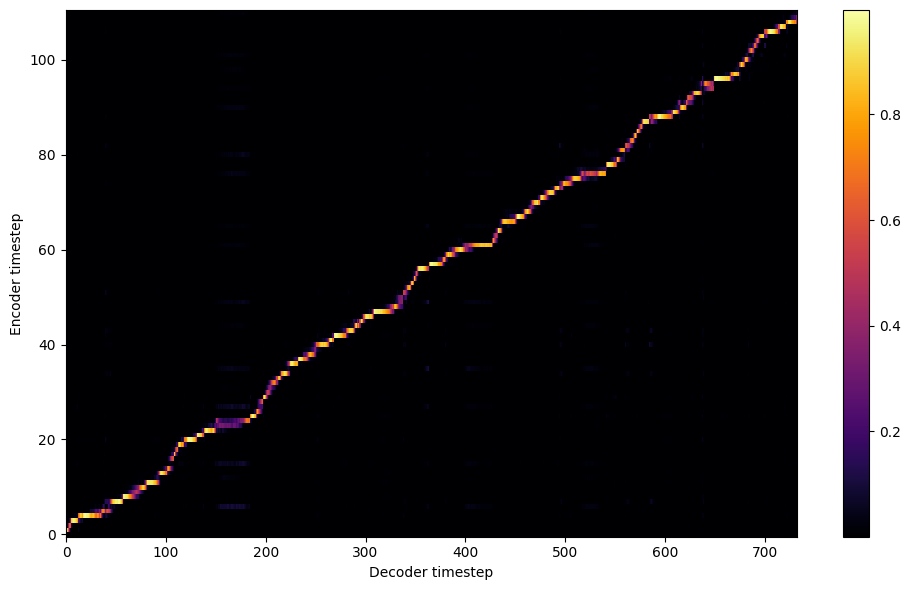


Starting Epoch: 1 Iteration: 18


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1 Validation loss 36:  0.308732  Time: 1.1m LR: 0.000300


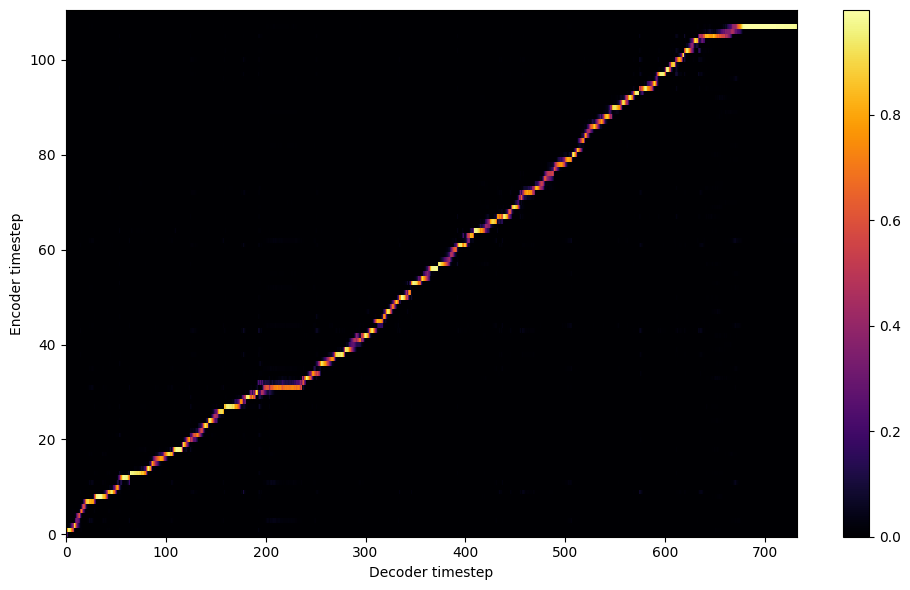


Starting Epoch: 2 Iteration: 36


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2 Validation loss 54:  0.284413  Time: 1.1m LR: 0.000300


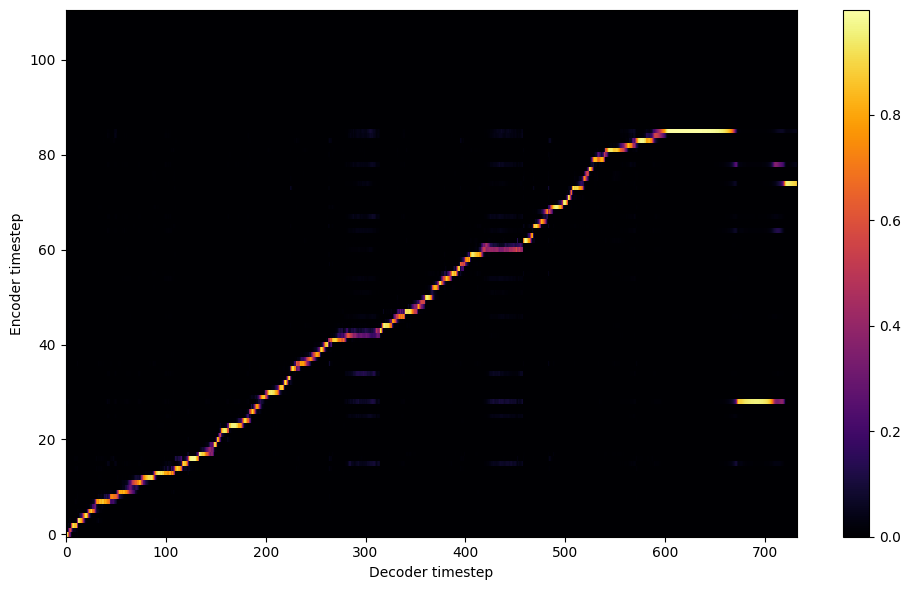


Starting Epoch: 3 Iteration: 54


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3 Validation loss 72:  0.283597  Time: 1.1m LR: 0.000300


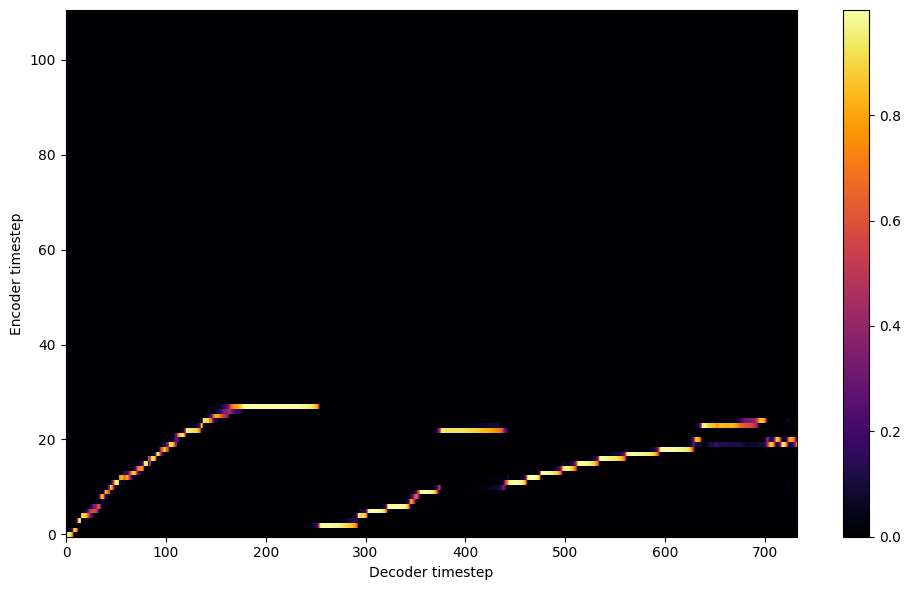


Starting Epoch: 4 Iteration: 72


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4 Validation loss 90:  0.271603  Time: 1.1m LR: 0.000300


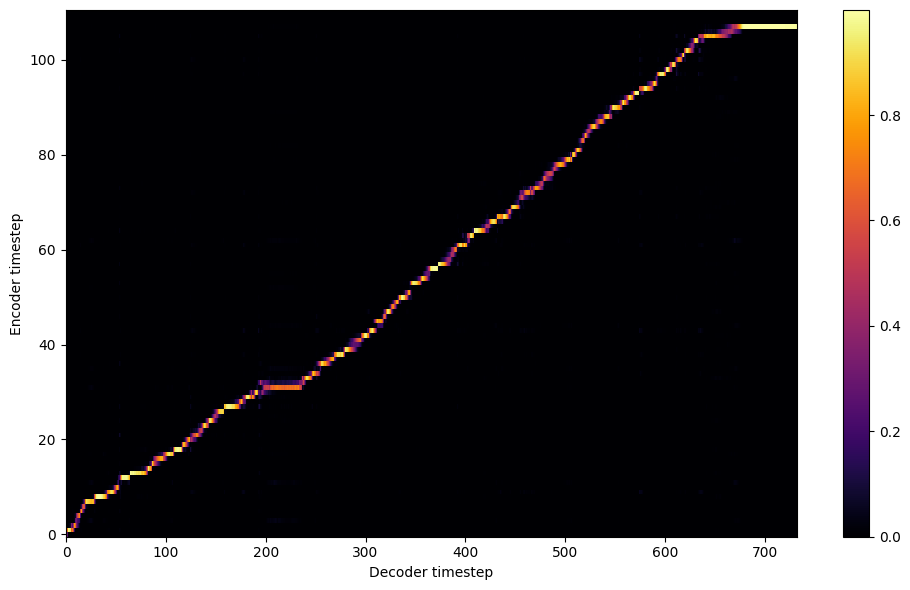


Starting Epoch: 5 Iteration: 90


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5 Validation loss 108:  0.279997  Time: 1.1m LR: 0.000300


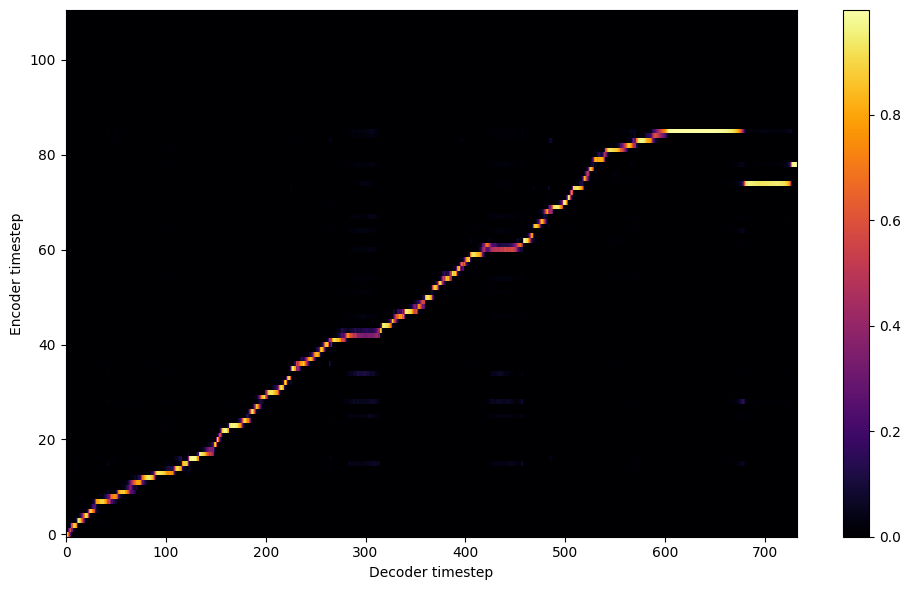


Starting Epoch: 6 Iteration: 108


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6 Validation loss 126:  0.265490  Time: 1.1m LR: 0.000300


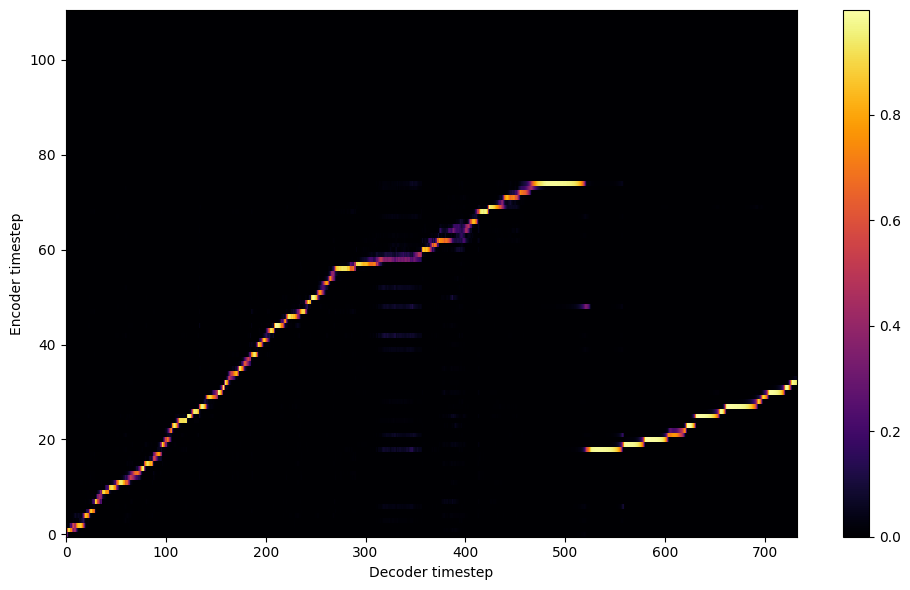


Starting Epoch: 7 Iteration: 126


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 7 Validation loss 144:  0.263378  Time: 1.1m LR: 0.000300


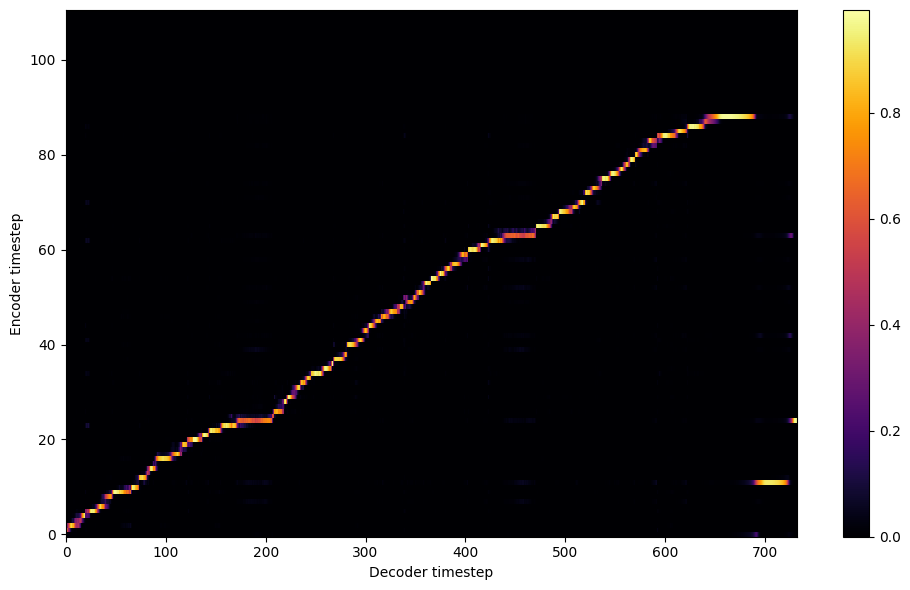


Starting Epoch: 8 Iteration: 144


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8 Validation loss 162:  0.282937  Time: 1.1m LR: 0.000300


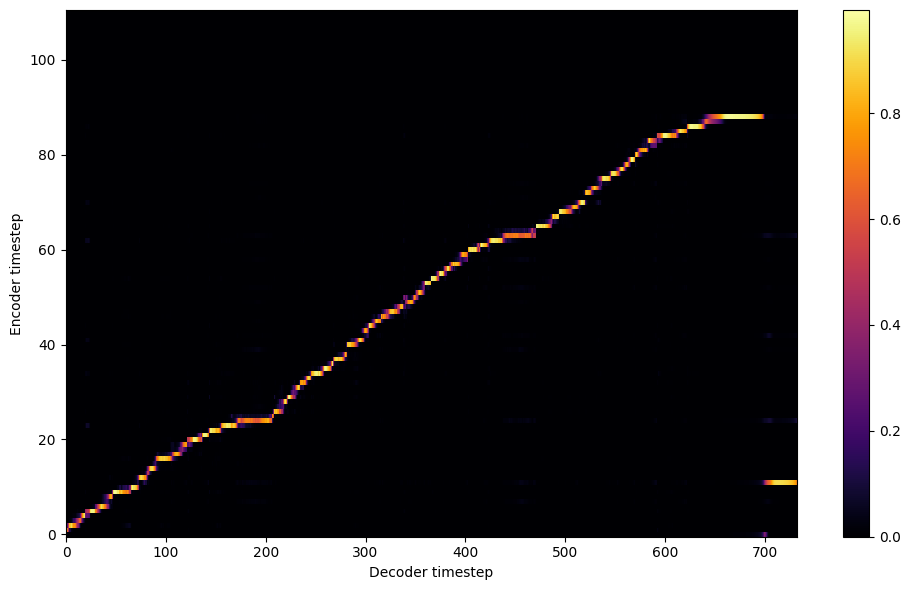


Starting Epoch: 9 Iteration: 162


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9 Validation loss 180:  0.260847  Time: 1.1m LR: 0.000300


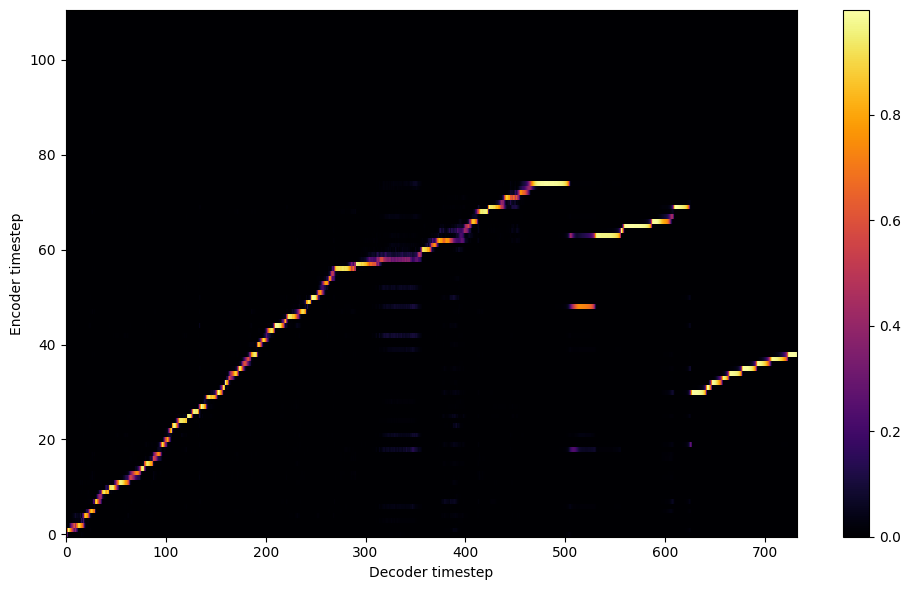

Saving model and optimizer state at iteration 180 to /content/drive/MyDrive/CPE_124_SERVICELEARNING/TTS_FirstTraining
Model Saved

Starting Epoch: 10 Iteration: 180


  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
#@markdown # <font color="pink"> **8. Begin training.** 🏋️
#@markdown ___
#@markdown ### How often to save (number of epochs)
#@markdown `10` by default. Raise this if you're hitting a rate limit. If you're using a particularly large dataset, you might want to set this to `1` to prevent loss of progress.
save_interval =  10#@param {type: "integer"}
#
#@markdown ### How often to backup (number of epochs)
#@markdown `-1` (disabled) by default. This will save extra copies of your model every so often, so you always have something to revert to if you train the model for too long. This *will* chew through your Google Drive storage.
backup_interval =  -1#@param {type: "integer"}
#

print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2,
      save_interval, backup_interval)

# **Final notes**

## A good training looks like this:
![img.png](https://media.discordapp.net/attachments/835971020569051216/851469553355587614/download_2.png)
